### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc. 'Cuz when us machines gonna take over the Earth, there won't be any more faces left. We want to preserve this data for future iterations. Yikes...

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [ ]:
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way: 
    #from gfile import download_list
    #download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
!unzip celeba.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

/home/leonsht/programming/yacv-tools-ws/venv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Torch version: 1.7.1+cu110
Using GPU


### Prepare Dataset

In [2]:
class CropCelebA64:
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [3]:
# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


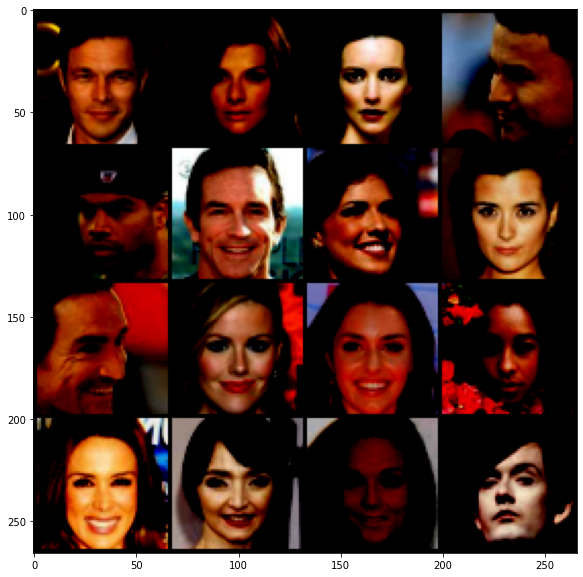

In [4]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it? 
* build some network that generates a face (small image)
* make up a __measure__ of __how good this face is__
* optimize with gradient descent :)


The only problem is: how can we engineers tell well-generated faces from bad? And i bet you we won't ask a designer for help. 

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample. 
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake. 
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [5]:
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [6]:
def conv_relu(inc, outc, kernel_size=4, stride=2, padding=1, act=lambda: nn.LeakyReLU(negative_slope=0.2), nobn=False):
    return nn.Sequential(
        nn.Conv2d(
            inc, outc,
            kernel_size=kernel_size,
            stride=stride, 
            padding=padding,
            bias=False,
        ),
        nn.Identity() if nobn else nn.BatchNorm2d(outc),
        act(),
    )

def upconv_relu(inc, outc, act=nn.LeakyReLU, kernel_size=2, padding=0, stride=1, nobn=False):    
    return nn.Sequential(
        nn.ConvTranspose2d(
            inc, outc, 
            stride=stride, 
            kernel_size=kernel_size, 
            padding=padding,
            bias=False
        ),
        nn.Identity() if nobn else nn.InstanceNorm2d(outc),
        act(),
    )

def mlp(channels):
    def dense_bn_relu(inc, outc):
        return nn.Sequential(
            nn.Linear(inc, outc),
            nn.ELU(),
        )
    
    return nn.Sequential(
        *[dense_bn_relu(i, o) for i, o in zip(channels[:-1], channels[1:])]
    )

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
CODE_SIZE = 128
DROP_RATE = 0.5
GMUL = 64

generator = nn.Sequential(
    # mlp([CODE_SIZE, 4 * CODE_SIZE]),
    Reshape([-1, CODE_SIZE, 1, 1]),
    upconv_relu(CODE_SIZE, 8 * GMUL, kernel_size=4, stride=1, padding=0), # to 4, 4
    upconv_relu(8 * GMUL, 4 * GMUL, kernel_size=4, stride=2, padding=1), # to 8, 8
    # nn.Dropout2d(p=DROP_RATE),
    upconv_relu(4 * GMUL, 2 * GMUL, kernel_size=4, stride=2, padding=1), # to 16, 16
    # nn.Dropout2d(p=DROP_RATE),
    upconv_relu(2 * GMUL, GMUL, kernel_size=4, stride=2, padding=1), # to 32, 32
    # nn.Dropout2d(p=DROP_RATE),
    upconv_relu(GMUL, 3, act=nn.Tanh, kernel_size=4, stride=2, padding=1, nobn=True), # to 64, 64
)

generator = generator.apply(weights_init)
if use_cuda:
    generator.cuda()

In [9]:
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator
* Discriminator is your usual convolutional network with interlooping convolution and pooling layers
* The network does not include dropout/batchnorm to avoid learning complications.
* We also regularize the pre-output layer to prevent discriminator from being too certain.

In [10]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.cuda() if use_cuda else batch.cpu()

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [11]:
DMUL = 64

discriminator = nn.Sequential(
    conv_relu(3, DMUL, kernel_size=4, stride=2, padding=1, nobn=True),  # to 32, 32
    conv_relu(DMUL, 2 * DMUL, kernel_size=4, stride=2, padding=1),  # to 16, 16
    conv_relu(2 * DMUL, 4 * DMUL, kernel_size=4, stride=2, padding=1),  # to 8, 8
    conv_relu(4 * DMUL, 8 * DMUL, kernel_size=4, stride=2, padding=1),  # to 4, 4
    conv_relu(8 * DMUL, 1, kernel_size=4, stride=1, padding=0, act=nn.Identity, nobn=True),  # to 1, 1
    Flatten(),
)

discriminator = discriminator.apply(weights_init)
if use_cuda: 
    discriminator.cuda()

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real
* Since discriminator is a differentiable neural network, we train both with gradient descent.

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* Regularize discriminator output weights to prevent explosion
* Train generator with __adam__ to speed up training. Discriminator trains with SGD to avoid problems with momentum.
* More: https://github.com/soumith/ganhacks


In [12]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    #logp_gen_is_real = F.logsigmoid(-disc_on_generated_data)   # log (1 - P(G(z))) -> min
    logp_gen_is_real = -F.logsigmoid(disc_on_generated_data)
    
    # patch_disc_on_generated_data = discriminator['patch_disc'](discriminator['encoder'](generated_data))
    # patch_logp_gen_is_real = F.logsigmoid(-patch_disc_on_generated_data)
    
    loss = logp_gen_is_real.mean() # + patch_logp_gen_is_real.mean()
    # min log (1 - P), where P - prob of being real 
    return loss

In [13]:
loss = generator_loss(sample_noise_batch(32))

print(loss)
assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.5362, device='cuda:0', grad_fn=<MeanBackward0>)


In [14]:
def discriminator_loss(real_data, generated_data, alpha=0.9):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    
    disc_on_real_data = discriminator(real_data)    
    real_logsigmoid = F.logsigmoid(disc_on_real_data)
    logp_real_is_real = real_logsigmoid
    
    #minus_real_logsigmoid = F.logsigmoid(-disc_on_real_data)
    #alpha = alpha + (1 - alpha) * torch.rand_like(real_logsigmoid).detach()
    #logp_real_is_real = alpha * real_logsigmoid + (1 - alpha) * minus_real_logsigmoid  # -> max
    loss_real = -logp_real_is_real.mean()
    
    loss_real.backward()
    
    disc_on_fake_data = discriminator(generated_data)
    
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)  # log (1 - P_fake) -> max
    loss_fake = -logp_gen_is_fake.mean()
    
    loss_fake.backward()
        
    return loss_real + loss_fake # + 1e-4 * discriminator.proj.weight.norm()

In [15]:
loss = discriminator_loss(sample_data_batch(32), generator(sample_noise_batch(32)))

print(loss)
assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.6272, device='cuda:0', grad_fn=<AddBackward0>)


### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [16]:
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images) != 0:
        images = ((images + 1) / 2).clip(0, 1)
    for i in range(nrow * ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [17]:
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
#disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))

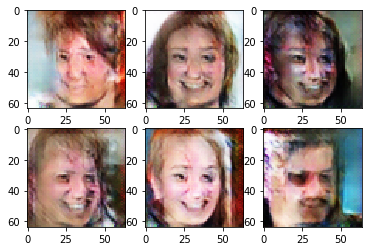

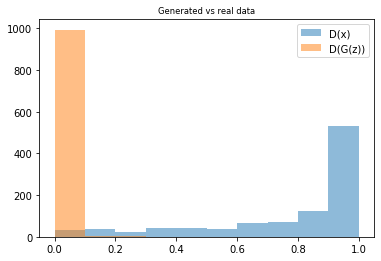

In [19]:
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

cringe_replay_buffer = []
alpha = 0.9

loss_diff_ema = 0.0

for epoch in range(5):
    for iteration, (batch, _) in enumerate(loader):
        
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        
        discriminator.zero_grad()
        d_loss = discriminator_loss(real_data, fake_data, alpha=alpha)
        # d_loss.backward()  # is inside
        disc_opt.step()
        
        
        generator.zero_grad()
        noise = sample_noise_batch(batch_size)
        g_loss = generator_loss(noise)
        # mean_loss = F.mse_loss(generator(noise).mean(dim=0), real_data.mean(dim=0))

        g_loss = g_loss # + 10.0 * mean_loss  # mean loss scale ~ 1e-2
        
        g_loss.backward()
        gen_opt.step()

            
        with torch.no_grad():
            g_loss = generator_loss(sample_noise_batch(batch_size))
            loss_diff_ema = 0.9 * loss_diff_ema + 0.1 * (g_loss - d_loss)
        
        print(f'itertion: {epoch}-{iteration}, loss_diff_ema: {loss_diff_ema:0.2f}, g: {g_loss:0.2f}, d: {d_loss:0.2f}', end='\r')
            
        if iteration % 100 == 0:
            display.clear_output(wait=True)
            sample_images(2, 3, True)
            sample_probas(1000)
        

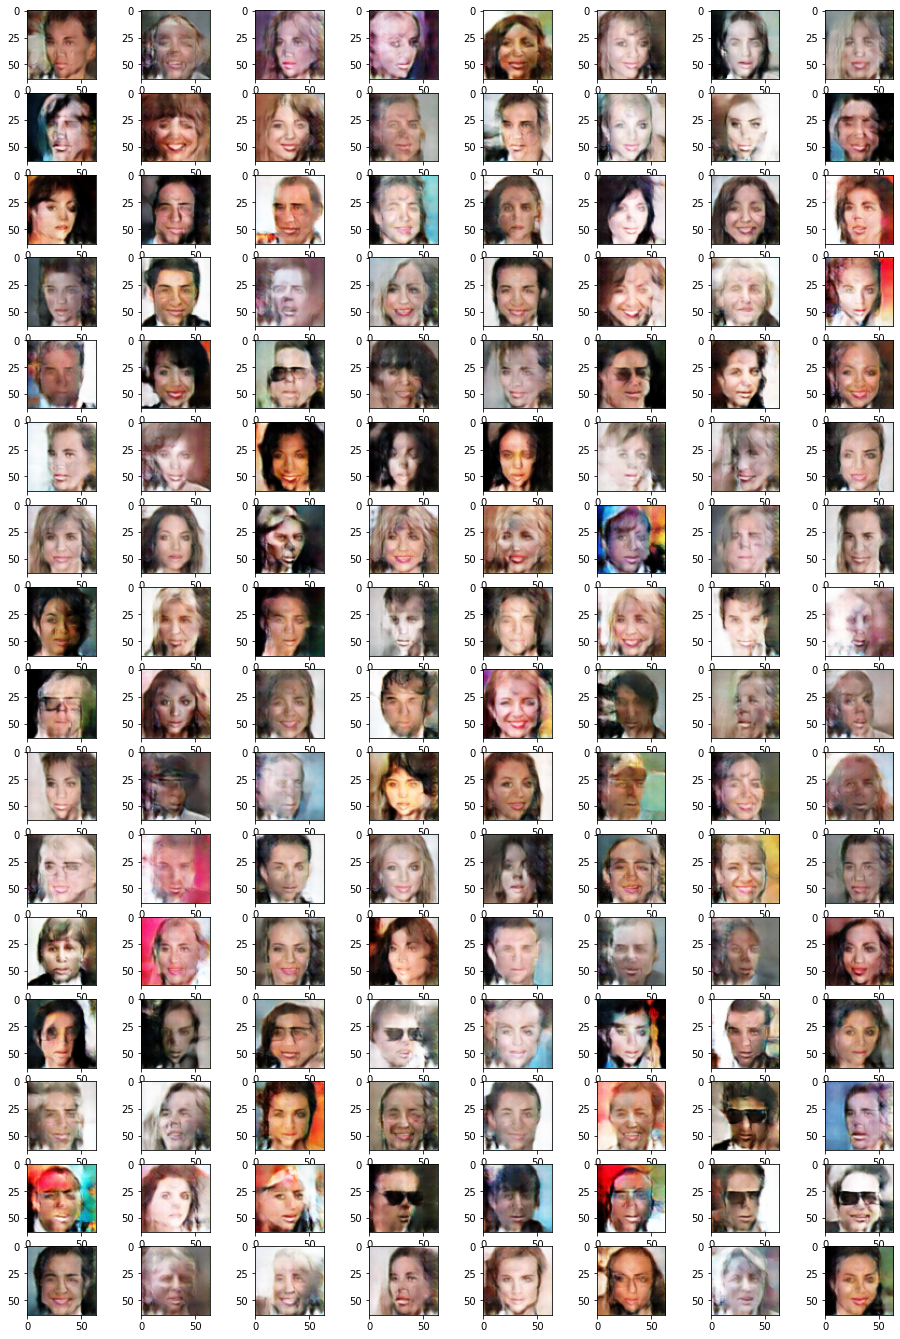

In [20]:
#!L
plt.figure(figsize=[16, 24])
sample_images(16, 8)

# Note: a no-nonsense neural network should be able to produce reasonably good images after 15k iterations
# By "reasonably good" we mean "resembling a car crash victim" or better